# BraTS Post-treatment Interactive Exploration

This notebook provides an end-to-end workspace for inspecting the BraTS 2025 post-treatment dataset, validating geometry and segmentation metadata, and building reusable visualizations/exports for clinical review.

## 1. Data Loading and Metadata Extraction

Load BraTS NIfTI volumes and segmentation masks, collect geometric metadata, and maintain reusable helpers for downstream steps.

In [1]:
from __future__ import annotations

import json
from dataclasses import dataclass
from functools import lru_cache
from pathlib import Path
from typing import Dict, Iterable, List, Mapping, Tuple

import imageio
import ipywidgets as widgets
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from IPython.display import HTML, clear_output, display
from matplotlib.colors import ListedColormap
from nibabel.orientations import aff2axcodes

# Dataset configuration
PROJECT_ROOT = Path("..").resolve()
DATA_ROOT = (PROJECT_ROOT / "training_data_additional").resolve()
MODALITIES = ("t1c", "t1n", "t2f", "t2w")
LABEL_MAP = {
    0: ("Background", "#00000000"),
    1: ("Enhancing Tumor", "#ff4f40"),
    2: ("Non-Enhancing Tumor", "#ffb347"),
    3: ("Peritumoral Edema", "#42c6ff"),
    4: ("Resection Cavity", "#9b59b6"),
}


def list_case_dirs(root: Path = DATA_ROOT) -> List[Path]:
    return sorted([p for p in root.iterdir() if p.is_dir()])


def infer_case_prefix(case_dir: Path) -> str:
    return case_dir.name


def load_nifti(path: Path) -> nib.Nifti1Image:
    if not path.exists():
        raise FileNotFoundError(path)
    return nib.load(str(path))


def get_volume(path: Path) -> np.ndarray:
    return load_nifti(path).get_fdata(dtype=np.float32)


def get_metadata(case_dir: Path) -> Dict[str, object]:
    prefix = infer_case_prefix(case_dir)
    t1c_path = case_dir / f"{prefix}-t1c.nii.gz"
    img = load_nifti(t1c_path)
    shape = img.shape
    spacing = tuple(float(round(v, 3)) for v in img.header.get_zooms()[:3])
    orientation = aff2axcodes(img.affine)
    return {
        "case_id": prefix,
        "shape": shape,
        "voxel_spacing": spacing,
        "orientation": orientation,
    }


def collect_metadata(root: Path = DATA_ROOT) -> pd.DataFrame:
    rows = []
    for case_dir in list_case_dirs(root):
        try:
            rows.append(get_metadata(case_dir))
        except FileNotFoundError:
            continue
    return pd.DataFrame(rows)


metadata_df = collect_metadata()
metadata_df.head()

,case_id,shape,voxel_spacing,orientation
0,BraTS-GLI-02405-100,"(182, 218, 182)","(1.0, 1.0, 1.0)","(L, A, S)"
1,BraTS-GLI-02405-101,"(182, 218, 182)","(1.0, 1.0, 1.0)","(L, A, S)"
2,BraTS-GLI-02406-100,"(182, 218, 182)","(1.0, 1.0, 1.0)","(L, A, S)"
3,BraTS-GLI-02407-100,"(182, 218, 182)","(1.0, 1.0, 1.0)","(L, A, S)"
4,BraTS-GLI-02408-100,"(182, 218, 182)","(1.0, 1.0, 1.0)","(L, A, S)"


## 2. Compute Image Geometry Consistency

Summarize dimensions, voxel spacing, and orientation across subjects to detect anomalies.

In [2]:
shape_counts = metadata_df["shape"].value_counts().rename_axis("shape").reset_index(name="count")
spacing_counts = metadata_df["voxel_spacing"].value_counts().rename_axis("voxel_spacing").reset_index(name="count")
orientation_counts = metadata_df["orientation"].value_counts().rename_axis("orientation").reset_index(name="count")

summary = {
    "num_cases": len(metadata_df),
    "unique_shapes": shape_counts.shape[0],
    "unique_spacings": spacing_counts.shape[0],
    "unique_orientations": orientation_counts.shape[0],
}

display(pd.DataFrame([summary]))
display(shape_counts)
display(spacing_counts)
display(orientation_counts)

,num_cases,unique_shapes,unique_spacings,unique_orientations
0,271,1,1,1


,shape,count
0,"(182, 218, 182)",271


,voxel_spacing,count
0,"(1.0, 1.0, 1.0)",271


,orientation,count
0,"(L, A, S)",271


## 3. Segmentation Label Analysis

Inspect unique label integers, validate tumor sub-region mapping, and compute dataset-wide distributions.

In [3]:
from collections import Counter


def collect_label_statistics(root: Path = DATA_ROOT) -> Tuple[pd.DataFrame, Counter, Dict[int, float]]:
    rows = []
    aggregate = Counter()
    for case_dir in list_case_dirs(root):
        prefix = infer_case_prefix(case_dir)
        seg_path = case_dir / f"{prefix}-seg.nii.gz"
        if not seg_path.exists():
            continue
        data = get_volume(seg_path)
        labels, counts = np.unique(np.rint(data).astype(np.int16), return_counts=True)
        total_voxels = int(np.prod(data.shape))
        record = {"case_id": prefix}
        case_counter = dict(zip(labels.astype(int), counts.astype(int)))
        aggregate.update(case_counter)
        for label, (name, _) in LABEL_MAP.items():
            voxels = case_counter.get(label, 0)
            record[f"voxels_label_{label}"] = voxels
            record[f"pct_label_{label}"] = 100.0 * voxels / total_voxels
        rows.append(record)
    df = pd.DataFrame(rows)
    total = sum(aggregate.values())
    aggregate_pct = {label: 100.0 * aggregate.get(label, 0) / total for label in LABEL_MAP}
    return df, aggregate, aggregate_pct


label_df, label_counts, label_pct = collect_label_statistics()

display(pd.DataFrame({
    "label": list(LABEL_MAP.keys()),
    "region": [LABEL_MAP[k][0] for k in LABEL_MAP],
    "color": [LABEL_MAP[k][1] for k in LABEL_MAP],
    "voxel_count": [label_counts.get(k, 0) for k in LABEL_MAP],
    "dataset_pct": [round(label_pct.get(k, 0.0), 3) for k in LABEL_MAP],
}))

,label,region,color,voxel_count,dataset_pct
0,0,Background,#00000000,1937164818,98.992
1,1,Enhancing Tumor,#ff4f40,541043,0.028
2,2,Non-Enhancing Tumor,#ffb347,14107863,0.721
3,3,Peritumoral Edema,#42c6ff,2990458,0.153
4,4,Resection Cavity,#9b59b6,2095490,0.107


In [4]:
label_df.head()

,case_id,voxels_label_0,pct_label_0,voxels_label_1,pct_label_1,voxels_label_2,pct_label_2,voxels_label_3,pct_label_3,voxels_label_4,pct_label_4
0,BraTS-GLI-02405-100,7195325,99.643998,4653,0.064437,8560,0.118543,12494,0.173022,0,0.000000
1,BraTS-GLI-02405-101,7185670,99.510292,404,0.005595,29376,0.406812,5582,0.077302,0,0.000000
2,BraTS-GLI-02406-100,7163401,99.201901,13001,0.180044,22832,0.316187,21798,0.301868,0,0.000000
3,BraTS-GLI-02407-100,7087552,98.151511,6344,0.087854,56424,0.781384,41691,0.577355,29021,0.401895
4,BraTS-GLI-02408-100,7072223,97.939228,1172,0.016230,114462,1.585120,33175,0.459422,0,0.000000


## 4. Multi-Modality Mask Overlay Visualization

Render sample slices for each modality with segmentation overlay colors to verify alignment.

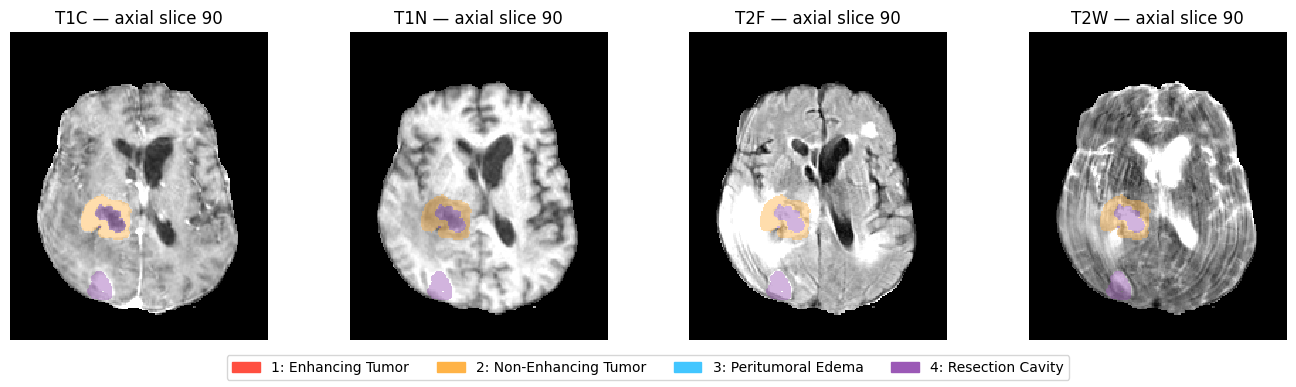

In [5]:
def normalize_volume(volume: np.ndarray) -> np.ndarray:
    finite = np.isfinite(volume)
    if not finite.any():
        return np.zeros_like(volume, dtype=np.float32)
    cleaned = volume[finite]
    lo, hi = np.percentile(cleaned, (1, 99))
    if np.isclose(lo, hi):
        lo, hi = float(cleaned.min()), float(cleaned.max())
    if np.isclose(lo, hi):
        return np.clip(volume, 0.0, 1.0)
    normed = (volume - lo) / (hi - lo)
    return np.clip(normed, 0.0, 1.0)


def prepare_slice(volume: np.ndarray, axis: int, index: int) -> np.ndarray:
    slicer = [slice(None)] * 3
    slicer[axis] = index
    data = volume[tuple(slicer)]
    if axis == 2:  # axial
        return np.rot90(data)
    if axis == 1:  # coronal
        return np.rot90(np.flipud(data))
    return np.rot90(np.flipud(data))  # sagittal


def build_segmentation_colormap() -> ListedColormap:
    rgba = [plt.matplotlib.colors.to_rgba(LABEL_MAP[label][1]) for label in sorted(LABEL_MAP)]
    return ListedColormap(rgba)


def load_case_volumes(case_id: str, root: Path = DATA_ROOT) -> Dict[str, np.ndarray]:
    case_dir = root / case_id
    volumes = {}
    for modality in MODALITIES:
        path = case_dir / f"{case_id}-{modality}.nii.gz"
        if path.exists():
            volumes[modality] = normalize_volume(get_volume(path))
    if not volumes:
        raise FileNotFoundError(f"No modalities found for {case_id}")
    return volumes


def load_segmentation(case_id: str, root: Path = DATA_ROOT) -> np.ndarray:
    seg_path = root / case_id / f"{case_id}-seg.nii.gz"
    if not seg_path.exists():
        raise FileNotFoundError(f"No segmentation for {case_id}")
    return np.rint(get_volume(seg_path)).astype(np.int16)


def plot_modalities_with_overlay(case_id: str, axis: str = "axial", fraction: float = 0.5) -> None:
    axis_map = {"sagittal": 0, "coronal": 1, "axial": 2}
    axis_idx = axis_map[axis]
    volumes = load_case_volumes(case_id)
    segmentation = load_segmentation(case_id)
    size = volumes[MODALITIES[0]].shape[axis_idx]
    slice_idx = int(np.clip(round(fraction * (size - 1)), 0, size - 1))

    cmap = build_segmentation_colormap()
    fig, axes = plt.subplots(1, len(volumes), figsize=(4.2 * len(volumes), 4))
    if len(volumes) == 1:
        axes = [axes]

    for ax, (modality, volume) in zip(axes, volumes.items()):
        img_slice = prepare_slice(volume, axis_idx, slice_idx)
        ax.imshow(img_slice, cmap="gray", interpolation="none")
        seg_slice = prepare_slice(segmentation, axis_idx, slice_idx)
        mask = np.ma.masked_where(seg_slice < 0.5, seg_slice)
        ax.imshow(mask, cmap=cmap, alpha=0.45, interpolation="none")
        ax.set_title(f"{modality.upper()} — {axis} slice {slice_idx}")
        ax.axis("off")

    handles = [plt.matplotlib.patches.Patch(color=LABEL_MAP[label][1], label=f"{label}: {LABEL_MAP[label][0]}")
               for label in sorted(LABEL_MAP) if label != 0]
    fig.legend(handles=handles, loc="lower center", ncol=min(4, len(handles)))
    plt.show()


plot_modalities_with_overlay(metadata_df.case_id.iloc[103])

## 5. Interactive Volume Inspection Widgets

Use `ipywidgets` to browse modalities, planes, and slices with segmentation overlays in real time.

In [ ]:
def render_single_slice(case_id: str, modality: str, axis: str, index: int, overlay: bool = True) -> None:
    axis_map = {"sagittal": 0, "coronal": 1, "axial": 2}
    volumes = load_case_volumes(case_id)
    volume = volumes[modality]
    segmentation = load_segmentation(case_id)
    axis_idx = axis_map[axis]
    img_slice = prepare_slice(volume, axis_idx, index)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img_slice, cmap="gray", interpolation="none")
    if overlay:
        seg_slice = prepare_slice(segmentation, axis_idx, index)
        cmap = build_segmentation_colormap()
        mask = np.ma.masked_where(seg_slice < 0.5, seg_slice)
        ax.imshow(mask, cmap=cmap, alpha=0.45, interpolation="none")
    ax.set_title(f"{case_id} — {modality.upper()} — {axis} slice {index}")
    ax.axis("off")
    plt.show()


def launch_interactive_viewer() -> widgets.VBox:
    if metadata_df.empty:
        raise RuntimeError("No cases loaded. Check DATA_ROOT path.")

    case_options = metadata_df.case_id.tolist()
    axis_options = ["sagittal", "coronal", "axial"]

    case_select = widgets.Dropdown(options=case_options, value=case_options[0], description="Case")
    modality_select = widgets.Dropdown(options=MODALITIES, value="t1c", description="Modality")
    axis_select = widgets.Dropdown(options=axis_options, value="axial", description="Axis")
    overlay_toggle = widgets.Checkbox(value=True, description="Overlay mask")
    slice_slider = widgets.IntSlider(value=0, min=0, max=1, step=1, description="Slice")
    output = widgets.Output()

    axis_map = {"sagittal": 0, "coronal": 1, "axial": 2}

    def update_slider(*_):
        volumes = load_case_volumes(case_select.value)
        axis_idx = axis_map[axis_select.value]
        size = volumes[modality_select.value].shape[axis_idx]
        slice_slider.max = max(size - 1, 0)
        if slice_slider.value > slice_slider.max:
            slice_slider.value = slice_slider.max // 2 if slice_slider.max > 0 else 0

    def render(*_):
        with output:
            clear_output(wait=True)
            render_single_slice(
                case_id=case_select.value,
                modality=modality_select.value,
                axis=axis_select.value,
                index=slice_slider.value,
                overlay=overlay_toggle.value,
            )

    # Wire events
    case_select.observe(lambda change: (update_slider(), render()), names="value")
    modality_select.observe(lambda change: (update_slider(), render()), names="value")
    axis_select.observe(lambda change: (update_slider(), render()), names="value")
    slice_slider.observe(lambda change: render(), names="value")
    overlay_toggle.observe(lambda change: render(), names="value")

    update_slider()
    render()

    controls = widgets.HBox([case_select, modality_select, axis_select, overlay_toggle])
    layout = widgets.VBox([controls, slice_slider, output])
    display(layout)
    return layout


launch_interactive_viewer();

## 6. Per-Case Histogram Statistics

Generate intensity histograms per modality and label-volume summaries to quantify patient-level variation.

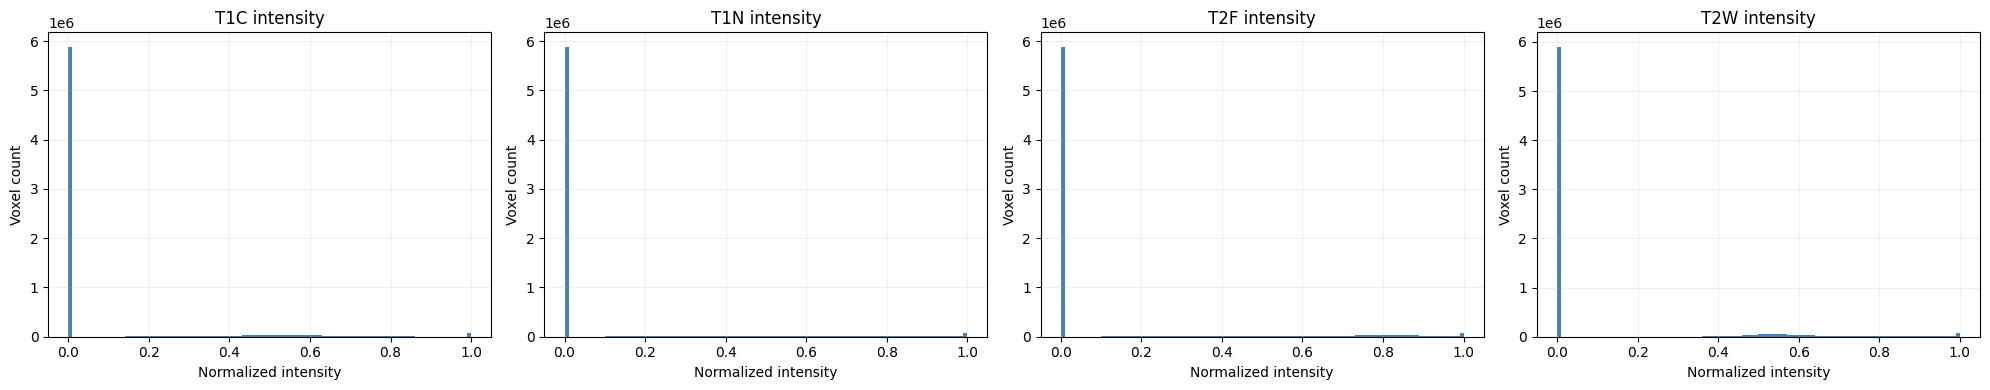

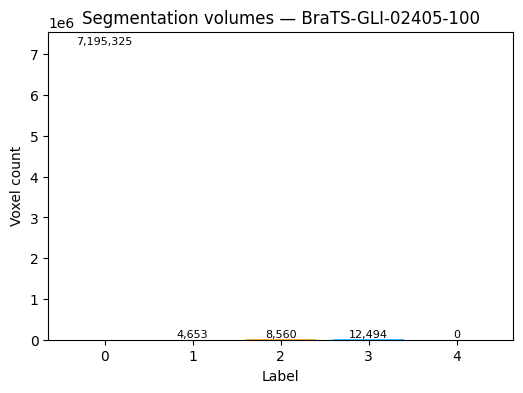

In [7]:
def plot_case_histograms(case_id: str) -> None:
    volumes = load_case_volumes(case_id)
    segmentation = load_segmentation(case_id)

    fig, axes = plt.subplots(1, len(MODALITIES), figsize=(5 * len(MODALITIES), 4))
    for ax, modality in zip(axes, MODALITIES):
        data = volumes[modality]
        ax.hist(data.flatten(), bins=100, range=(0.0, 1.0), color="steelblue")
        ax.set_title(f"{modality.upper()} intensity")
        ax.set_xlabel("Normalized intensity")
        ax.set_ylabel("Voxel count")
        ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

    label_counts_case = [int((segmentation == label).sum()) for label in LABEL_MAP]
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar([str(label) for label in LABEL_MAP], label_counts_case, color=[LABEL_MAP[label][1] for label in LABEL_MAP])
    ax.set_title(f"Segmentation volumes — {case_id}")
    ax.set_xlabel("Label")
    ax.set_ylabel("Voxel count")
    for rect, count in zip(bars, label_counts_case):
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height(), f"{count:,}", ha="center", va="bottom", fontsize=8)
    plt.show()


plot_case_histograms(metadata_df.case_id.iloc[0])

## 7. Batch GIF Generation Pipeline

Convert volume slices to animations for quality review, exporting per-case GIFs with optional segmentation overlays.

In [8]:
def render_gif_frame(volume: np.ndarray, segmentation: np.ndarray | None, axis_idx: int, index: int, overlay: bool) -> np.ndarray:
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(prepare_slice(volume, axis_idx, index), cmap="gray", interpolation="none")
    if overlay and segmentation is not None:
        seg_slice = prepare_slice(segmentation, axis_idx, index)
        mask = np.ma.masked_where(seg_slice < 0.5, seg_slice)
        cmap = build_segmentation_colormap()
        ax.imshow(mask, cmap=cmap, alpha=0.45, interpolation="none")
    ax.axis("off")
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return frame


def create_case_gif(
    case_id: str,
    modality: str = "t1c",
    axis: str = "axial",
    overlay: bool = True,
    step: int = 2,
    output_dir: Path = PROJECT_ROOT / "outputs" / "gifs",
    fps: int = 15,
) -> Path:
    axis_map = {"sagittal": 0, "coronal": 1, "axial": 2}
    output_dir.mkdir(parents=True, exist_ok=True)

    volumes = load_case_volumes(case_id)
    segmentation = load_segmentation(case_id) if overlay else None
    volume = volumes[modality]
    axis_idx = axis_map[axis]

    frames = []
    for idx in range(0, volume.shape[axis_idx], step):
        frames.append(render_gif_frame(volume, segmentation, axis_idx, idx, overlay))

    gif_path = output_dir / f"{case_id}_{modality}_{axis}.gif"
    imageio.mimsave(gif_path, frames, fps=fps)
    print(f"Saved GIF -> {gif_path}")
    return gif_path


# Example (commented to avoid long runs by default)
# create_case_gif(metadata_df.case_id.iloc[0], modality="t2f", axis="axial", overlay=True, step=3)

print("GIF pipeline ready — uncomment the example above to generate outputs.")

GIF pipeline ready — uncomment the example above to generate outputs.
